# Supplementary Notebook S07: Making the acetate producing <i>G. Thermo</i> GEM

This notebook is supplementary to the the research paper titled:

Optimizing acetogenic CO(2) utilization through metabolic and process engineering highlights the potential of thermophilic bioproduction

The purpose of this notebook is to add the pathways and delete genes in the <i>Geobacillus thermoglucosidasius</i> GEM, to make it resemble the acetate producing strain.

Written by Daniel Bavnhøj

In [1]:
import cobra
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite
from IPython.display import Image

In [2]:
pth = read_sbml_model("../../Models/PublishedModels/p-thermo.xml")

Using license file /Users/phivri/gurobi.lic
Academic license - for non-commercial use only - expires 2022-07-23


First, I will take a look at the growth (aerobicly and anaerobicly) without manipulating the model.

In [3]:
with pth:
    WT_growth = pth.optimize()
    print("Aerobic growth:", round(WT_growth.objective_value,3), "h^-1")

with pth:
    medium = pth.medium
    medium["EX_o2_e"] = 0.0
    pth.medium = medium
    WT_growth_ana = pth.optimize()
    print("Anaerobic growth:", round(WT_growth_ana.objective_value,3), "h^-1")
    #This does not compare to the p-thermo.xml publication

Aerobic growth: 0.666 h^-1
Anaerobic growth: 0.0 h^-1


Vivienne mentioned that some extra metabolites need to be added to the model for it to grow anaerobically (they can only be synthesized when oxygen is presnt). Vivienne also mentioned that adding trace amounts of oxygen (Value > 0.005) would result in growth of the model.

In [4]:
with pth:
    medium = pth.medium
    medium["EX_o2_e"] = 0.005
    pth.medium = medium
    WT_growth_ana = pth.optimize()
    print("Growth rate:", round(WT_growth_ana.objective_value,3), "h^-1")

Growth rate: 0.124 h^-1


However, the trace elements will be added, to make the model resemble the medium in reality, so it can actually grow anaerobically. <br><br>

<center><i>
This analysis highlighted a complex combination of components that cannot be synthesized anaerobically: thiamine, biotin, folate, vitamin B12, spermine, spermidine and hemin. Additionally, iron(III) must be available in the medium to allow porphyrin biosynthesis [1].
</i></center>

Cobamide coenzyme is also needed, which is seen in the 54. Minimum oxygen requirement.ipynb notebook pusblished with the model paper [1]. The code below has adapted from that notebook.

Therefore, these reactions will be added as sink reactions (to make the model take up these metabolites) to make the model able to grow anaerobically.

In [5]:
with pth:
    #Add Biotine
    pth.add_boundary(pth.metabolites.btn_c, type = 'sink', reaction_id = 'sink_btn')
    #Add thiamine - as this sink
    pth.add_boundary(pth.metabolites.thmpp_c , type = 'sink', reaction_id = 'sink_thmpp')
    #Add spermine
    pth.add_boundary(pth.metabolites.sprm_c, type = 'sink', reaction_id = 'sink_sprm')
    #add spermidine
    pth.add_boundary(pth.metabolites.spmd_c, type = 'sink', reaction_id = 'sink_spmd')
    #Add Cobamide coenzyme
    pth.add_boundary(pth.metabolites.adocbl_c, type = 'sink', reaction_id = 'sink_adocbl')
    #Add folate
    pth.add_boundary(pth.metabolites.get_by_id('10fthf_c') , type = 'sink', reaction_id = 'sink_10fthf')
    #Add iron(III)
    pth.add_boundary(pth.metabolites.fe3_c , type = 'sink', reaction_id = 'sink_fe3')
    #Add protoheme
    pth.add_boundary(pth.metabolites.pheme_c , type = 'sink', reaction_id = 'sink_pheme')
    #set to anaerobic
    with pth:
        WT_growth = pth.optimize()
        print("Growth rate:", round(WT_growth.objective_value,3), "h^-1")
        medium = pth.medium
        medium["EX_o2_e"] = 0.0
        pth.medium = medium
        WT_growth_ana = pth.optimize()
        print("Growth rate:", round(WT_growth_ana.objective_value,3), "h^-1")

Growth rate: 0.666 h^-1
Growth rate: 0.124 h^-1


Now, the model grows anaerobically and the aerobic growth wasn't broken!

In [6]:
cobra.io.write_sbml_model(pth, "../../Models/p-thermo_anaerob.xml")

## Making the acetone producing strain

The acetone producing <i>G. thermoglucosidasius</i> strain has been made by Ivan Pogrebnyakov. The pathway is shown below. LDH has been knocked out, whereas the aldh has not been knocked out, but could be an interesting K/O target, as all acetyl-CoA would then be funneled to acetone.

Therefore, I will K/O (remove) the LDH reaction from the model, and also try to remove the ALDH (ACALD in the model) reaction, to see if it interferes with the growht and give a better picture the actual organism.

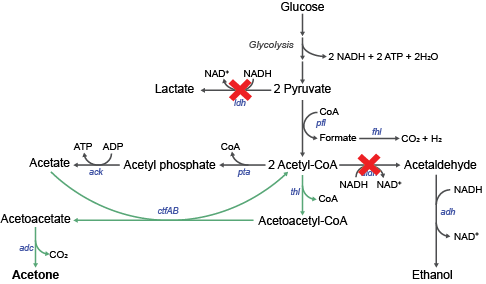

In [7]:
Image("../../Figures/acetone_pathway.png")

In [8]:
pth.reactions.LDH_L

Reaction identifier,LDH_L
Name,(S)-Lactate:NAD+ oxidoreductase
Memory address,0x07f96ec75fbe0
Stoichiometry,lac__L_c + nad_c <=> h_c + nadh_c + pyr_c (S)-Lactate + NAD+ <=> H+ + NADH + Pyruvate
GPR,RTMO04782 or RTMO04783
Lower bound,-1000.0
Upper bound,1000.0


In [9]:
pth.remove_reactions(["LDH_L"])

/Users/phivri/opt/anaconda3/envs/dFBACoCultivation/lib/python3.6/site-packages/cobra/core/group.py:107: UserWarning: need to pass in a list
  warn("need to pass in a list")


In [10]:
try:
    pth.reactions.LDH_L
except AttributeError:
    print("The LDH reaction has been removed successfully.")

The LDH reaction has been removed successfully.


See if theres any any growth differences between the wt and LDH KO. This will be done in both aerobic and anaerobic medium.

In [11]:
with pth:
    LDH_KO_growth = pth.optimize()
    print("Aerobic growth:", round(LDH_KO_growth.objective_value,3), "h^-1")
    
    medium = pth.medium
    medium["EX_o2_e"] = 0.0
    pth.medium = medium
    LDH_KO_growth_ana = pth.optimize()
    print("Anaerobic growth:", round(LDH_KO_growth_ana.objective_value,3), "h^-1")
    
   
print("Growth difference after LDH K/O:", round(LDH_KO_growth.objective_value - WT_growth.objective_value,3), "h^-1")
print("Anaerobic growth difference after LDH K/O:", round(LDH_KO_growth_ana.objective_value - WT_growth_ana.objective_value,3), "h^-1")

Aerobic growth: 0.666 h^-1
Anaerobic growth: 0.0 h^-1
Growth difference after LDH K/O: -0.001 h^-1
Anaerobic growth difference after LDH K/O: -0.124 h^-1


As seen form above, introducing the LDH K/O, does not affect the growth of Geobacillus. 

## Other genes worth knocking out

### ACALD K/O
I will try to remove ACALD, to see if it causes any growth defects. It could also be interesting to see if the model with this K/O would produce more acetone than the one with only the LDH K/O.

In [12]:
pth.reactions.ACALD

Reaction identifier,ACALD
Name,acetaldehyde:NAD+ oxidoreductase (CoA-acetylating)
Memory address,0x07f96ec682f98
Stoichiometry,acald_c + coa_c + nad_c <=> accoa_c + h_c + nadh_c Acetaldehyde + CoA + NAD+ <=> Acetyl-CoA + H+ + NADH
GPR,RTMO01253 or RTMO02838 or RTMO03546 or RTMO04740 or RTMO01888
Lower bound,-1000.0
Upper bound,1000.0


In [13]:
with pth:
    pth.remove_reactions(["ACALD"])
    ACALD_KO_growth = pth.optimize()
    print("Aerobic growth:", round(ACALD_KO_growth.objective_value,3), "h^-1")

    medium = pth.medium
    medium["EX_o2_e"] = 0.0
    pth.medium = medium
    
    ACALD_KO_growth_ana = pth.optimize()
    print("Anaerobic growth:", round(ACALD_KO_growth_ana.objective_value,3), "h^-1")
    
print("Growth difference after ACALD and LDH K/O:", round(ACALD_KO_growth.objective_value - LDH_KO_growth.objective_value,3), "h^-1")
print("Anaerobic growth difference after ACALD and LDH K/O:", round(ACALD_KO_growth_ana.objective_value - LDH_KO_growth_ana.objective_value,3), "h^-1")

Aerobic growth: 0.666 h^-1
Anaerobic growth: 0.0 h^-1
Growth difference after ACALD and LDH K/O: -0.0 h^-1
Anaerobic growth difference after ACALD and LDH K/O: 0.0 h^-1


There's a difference in anaerobic growth after removal of the ACALD reaction.

However, as growth doesn't go to 0, it could still be worth pursuing, if the strain predicts higher acetone yields.

### PTA K/O
ACALD proved to be a possible target for K/O. However, it would also be very interesting to knock out PTA, as this is the first reaction in the conversion of Acetyl-CoA -> Acetate. Therefore, I will also see what K/O of PTA predicts.

In [14]:
with pth:
    pth.remove_reactions(["PTAr"])
    PTA_KO_growth = pth.optimize()
    print("Aerobic growth:", round(PTA_KO_growth.objective_value,3), "h^-1")

    medium = pth.medium
    medium["EX_o2_e"] = 0.0
    pth.medium = medium
    
    PTA_KO_growth_ana = pth.optimize()
    print("Anaerobic growth:", round(PTA_KO_growth_ana.objective_value,3), "h^-1")
    
print("Growth difference after PTA and LDH K/O:", round(PTA_KO_growth.objective_value - LDH_KO_growth.objective_value,3), "h^-1")
print("Anaerobic growth difference after PTA and LDH K/O:", round(PTA_KO_growth_ana.objective_value - LDH_KO_growth_ana.objective_value,3), "h^-1")

Aerobic growth: 0.666 h^-1
Anaerobic growth: 0.0 h^-1
Growth difference after PTA and LDH K/O: 0.0 h^-1
Anaerobic growth difference after PTA and LDH K/O: 0.0 h^-1


This shows that the PTA reaction could also be worth pursuing as a knock out. However, it would also be nice to see if both ACALD and PTA could be knocked out simutaniously.

### K/O of both ACALD and PTA

In [15]:
with pth:
    pth.remove_reactions(["ACALD","PTAr"])
    ACALD_PTA_KO_growth = pth.optimize()
    print("Aerobic growth:", round(ACALD_PTA_KO_growth.objective_value,3), "h^-1")

    medium = pth.medium
    medium["EX_o2_e"] = 0.0
    pth.medium = medium
    
    ACALD_PTA_KO_growth_ana = pth.optimize()
    print("Anaerobic growth:", round(PTA_KO_growth_ana.objective_value,3), "h^-1")
    
print("Growth difference after ACALD and PTA K/O compared to only LDH K/O:", round(ACALD_PTA_KO_growth.objective_value - LDH_KO_growth.objective_value,3), "h^-1")
print("Anaerobic growth difference after ACALD and PTA K/O compared to only LDH K/O:", round(ACALD_PTA_KO_growth_ana.objective_value - LDH_KO_growth_ana.objective_value,3), "h^-1")

Aerobic growth: 0.666 h^-1
Anaerobic growth: 0.0 h^-1
Growth difference after ACALD and PTA K/O compared to only LDH K/O: -0.0 h^-1
Anaerobic growth difference after ACALD and PTA K/O compared to only LDH K/O: 0.0 h^-1


Overall the model predicts worse anaerobic growth after knocking out acetate related genes.

## Introducing the Acetone pathway

The 3 reactions in green need to be added to the GSM:

\begin{align}
ctfAB-ac&: Acetate + Acetoacetyl-CoA => Acetyl-CoA + Acetoacetate \tag{1.1} \\
ctfAB-bu&: Butyrate + Acetoacetyl-CoA => Butyryl-CoA + Acetoacetate \tag{1.2} \\
thl&: 2Acetyl-CoA => Acetoacetyl-CoA + CoA \tag{2}\\
adc&: Acetoacetate => Acetone + CO2 \tag{3}\\
\end{align}

All reactions are irriversible as it requires much energy to reattach CoA or cleave the molecules created by hydrolysis hydrolysis of CoA.

As ctfAB can catalyze two reactions, with Acetate/Butyrate and Acetoacetyl-CoA as reactants (eq 1.1-1.2), both should be added to the model [2].

I'll start by making the acetone metabolites and adding them to the model.

In [16]:
Acetone = Metabolite(
    'act_c',
    formula='C3H6O',
    name='Acetone',
    compartment='c')
Acetone_out = Metabolite(
    'act_e',
    formula='C3H6O',
    name='Acetone',
    compartment='e')
pth.add_metabolites([Acetone, Acetone_out])

Next, I'll make the 4 reactions described above.

As the reactions are supposed to be irriversible, the bounds are not changed, as the default is 0, 1000 (lower, upper).

In [17]:
ctfAB_ac = Reaction("ctfAB_ac")
ctfAB_ac.name = "Acetate-acetoacetate CoA-transferase"

ctfAB_ac.add_metabolites({
    pth.metabolites.ac_c: -1.0,      #Acetate
    pth.metabolites.aacoa_c: -1.0,   #Acetoacetyl-CoA
    pth.metabolites.acac_c: 1.0,     #Acetoacetate
    pth.metabolites.accoa_c: 1.0,    #Acetyl-CoA
    pth.metabolites.h_c: 1.0
})
print(ctfAB_ac.check_mass_balance())    #ensure correct mass balance
print(ctfAB_ac.bounds)                  #Ensure correct bounds
print(ctfAB_ac.reaction)                #Ensure correct reaction

{}
(0.0, 1000.0)
aacoa_c + ac_c --> acac_c + accoa_c + h_c


In [18]:
ctfAB_bu = Reaction("ctfAB_bu")
ctfAB_bu.name = "Butyrate-acetoacetate CoA-transferase"

ctfAB_bu.add_metabolites({
    pth.metabolites.but_c: -1.0,     #Butyrate
    pth.metabolites.aacoa_c: -1.0,   #Acetoacetyl-CoA
    pth.metabolites.acac_c: 1.0,     #Acetoacetate    
    pth.metabolites.btcoa_c: 1.0,    #Butyryl-CoA
    pth.metabolites.h_c: 1.0
})
print(ctfAB_bu.check_mass_balance())    #ensure correct mass balance
print(ctfAB_bu.reaction)                #Ensure correct reaction

{}
aacoa_c + but_c --> acac_c + btcoa_c + h_c


In [19]:
thl = Reaction("THL")
thl.name = "acetyl-CoA C-acetyltransferase"

thl.add_metabolites({
    pth.metabolites.accoa_c: -2.0,     #Acetyl-coa
    pth.metabolites.h_c: -1.0,
    pth.metabolites.aacoa_c: 1.0,     #Acetoacetyl-CoA
    pth.metabolites.coa_c: 1.0
})
print(thl.check_mass_balance())    #ensure correct mass balance
print(thl.reaction)                #Ensure correct reaction

{}
2.0 accoa_c + h_c --> aacoa_c + coa_c


In [20]:
adc = Reaction("ADC")
adc.name = "acetoacetate decarboxylase"

adc.add_metabolites({
    pth.metabolites.acac_c: -1.0,     #Acetoacetate
    pth.metabolites.h_c: -1.0, 
    pth.metabolites.act_c: 1.0,
    pth.metabolites.co2_c: 1.0
})
print(adc.check_mass_balance())    #ensure correct mass balance
print(adc.reaction)                #Ensure correct reaction

{}
acac_c + h_c --> act_c + co2_c


Lastly, I will make the acetone Acetone transporter and exchange to enable transport of acetone (as per recomendation of Vivienne instead of just adding a sink reaction). The reaction is supposed to be irreiversible, as the expectation is that acetone is volatile and will exit the fermentation broth quickly after coming out of the cell.

In [21]:
actT = Reaction("actT")
actT.name = "Acetone transporter"
actT.add_metabolites({ 
    pth.metabolites.act_c: -1.0,
    pth.metabolites.act_e: 1.0,
})
actT

Reaction identifier,actT
Name,Acetone transporter
Memory address,0x07f96ed929780
Stoichiometry,act_c --> act_e Acetone --> Acetone
GPR,
Lower bound,0.0
Upper bound,1000.0


In [22]:
act_ex = Reaction("EX_act_e")
act_ex.name = "Acetone exchange"
act_ex.add_metabolites({ 
    pth.metabolites.act_e: -1.0,
})
act_ex

Reaction identifier,EX_act_e
Name,Acetone exchange
Memory address,0x07f96edc465f8
Stoichiometry,act_e --> Acetone -->
GPR,
Lower bound,0.0
Upper bound,1000.0


Adding all the reactions to the model.

In [23]:
pth.add_reactions([ctfAB_ac, ctfAB_bu, thl, adc, actT, act_ex])

Checking if the acetone exchange has been added properly. If this is added properly, I assume that all of the reactions will be added correctly.

In [24]:
pth.exchanges.EX_act_e

Reaction identifier,EX_act_e
Name,Acetone exchange
Memory address,0x07f96edc465f8
Stoichiometry,act_e --> Acetone -->
GPR,
Lower bound,0.0
Upper bound,1000.0


Checking if this disables model growth and/or enables production of acetone.

In [25]:
with pth:
    pth.objective = "actT"
    print(pth.summary())

Objective
1.0 actT = 14.136142857142866

Uptake
------
Metabolite     Reaction  Flux  C-Number   C-Flux
  glc__D_e  EX_glc__D_e    10         6  100.00%
      o2_e      EX_o2_e 3.455         0    0.00%

Secretion
---------
Metabolite  Reaction   Flux  C-Number  C-Flux
     act_e  EX_act_e -14.14         3  70.68%
     co2_e  EX_co2_e -17.59         1  29.32%
     h2o_e  EX_h2o_e -17.59         0   0.00%



The model is now able to produce acetone and secrete it! This was only a test, to show that it works, and it will not be implemented like this, as ALL carbon flux goes to the acetone pathway, i.e. no c-flux to biomass - which won't be the case in reality.

I will save this model, as it will be used for dFBA.

In [26]:
cobra.io.write_sbml_model(pth, "../../Models/p-thermo_anaerob_actn.xml")

## Conclusion
The acetone pathway has now been included in the model, as well as enabled production and secretion of acetone. Now, it can now be used for dFBA!

[1] Viviënne Mol et al., “Genome-Scale Metabolic Modelling of P. Thermoglucosidasius NCIMB 11955 Reveals Metabolic Bottlenecks in Anaerobic Metabolism,” BioRxiv, February 1, 2021, 2021.02.01.429138, https://doi.org/10.1101/2021.02.01.429138.

[2] Le Yu et al., “Metabolic Engineering of Clostridium Tyrobutyricum for N-Butanol Production: Effects of CoA Transferase,” Applied Microbiology and Biotechnology 99, no. 11 (June 1, 2015): 4917–30, https://doi.org/10.1007/s00253-015-6566-5.